# Quantum Binary Classification

## Fix Random Parameters

In quantum binary classification tasks, we typically fix the random seed to ensure reproducibility. This allows consistent behavior across runs when generating random parameters such as `inputs`, `weights`, or dataset splits.

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn import datasets, preprocessing

from isqtools import IsqCircuit
from isqtools.backend import TorchBackend
from isqtools.neural_networks import TorchLayer


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


setup_seed(222)

## Create a Binary Classification Dataset

We create a simple binary classification dataset. The input `x` is a 2D array with values normalized to the range [−π,π]. The labels `y` take values from the set {0,1}, representing the two classes.

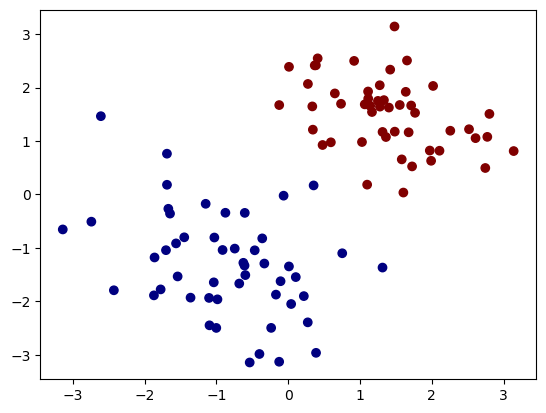

In [2]:
x, y = datasets.make_classification(
    n_features=2,
    n_redundant=0,
    n_samples=100,
    n_clusters_per_class=1,
    class_sep=1.3,
)

scaler = preprocessing.MinMaxScaler(feature_range=(-np.pi, np.pi))
x = scaler.fit_transform(x)
plt.scatter(x[:, 0], x[:, 1], c=y, cmap="jet")

To inspect the labels `y` in your binary classification dataset, you can simply print them out:

In [3]:
print(y)

[1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 0 0 0 1 0
 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 1
 0 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0]


## Define the Quantum Machine Learning Network

The quantum circuit for binary classification should be defined in an `.isq` file named `binary_classification.isq`. We use `tempfile`to simulate here.

In [4]:
FILE_CONTENT = """\
import std;


param inputs[], weights[];
qbit q[2];
int pauli_inx[] = [2, 2];
// this means Z0Z1
// using arrays for pauli measurement, 
// X:0, Y:1, Z:2, I:3

procedure single_h(qbit q[]) {
    for i in 0:q.length {
        H(q[i]);
    }
}

procedure adjacent_cz(qbit q[]) {
    for i in 0:q.length-1 {
        CZ(q[i], q[i+1]);
    }
}

procedure encode_inputs(qbit q[], int start_idx) {
    for i in 0:q.length {
        Rz(inputs[i+start_idx], q[i]);
    }
}

procedure encode_weights(qbit q[], int start_idx) {
    for i in 0:q.length {
        Ry(weights[i+start_idx], q[i]);
    }
    for i in 0:q.length {
        Rx(weights[i+start_idx+q.length], q[i]);
    }
}

procedure pauli(int puali_idx[], qbit q[]) {
    for i in 0:q.length {
        if (puali_idx[i] == 0) {
            H(q[i]);
            M(q[i]);
        }
        if (puali_idx[i] == 1) {
            X2P(q[i]);
            M(q[i]);
        }
        if (puali_idx[i] == 2) {
            M(q[i]);
        }
        if (puali_idx[i] == 3) {
            continue;
        }
    }
}

procedure main() {

    single_h(q);
    encode_inputs(q, 0);
    adjacent_cz(q);

    encode_weights(q, 0);
    adjacent_cz(q);

    encode_weights(q, 4);
    adjacent_cz(q);

    pauli(pauli_inx, q);
}"""

Create a quantum machine learning network. Here we use 2 qubits and define two parameters: `inputs` and `weights`. The result is obtained using Pauli measurement (Z0Z1). Since the Pauli measurement result lies in the range [-1, 1], we apply a simple mathematical transformation to map the circuit's output to the range [0, 1], which is more suitable for our binary classification task.

We then create `qnn` from the `circuit`. In addition to specifying the number of weights, we also enable the `vmap` method. When using `vmap`, we set `in_dims=(0, None)`, which means that the first dimension (dim=0) of the first argument inputs is vectorized, while the second argument weights is not. This setup aligns with the batch mode used in neural network training.

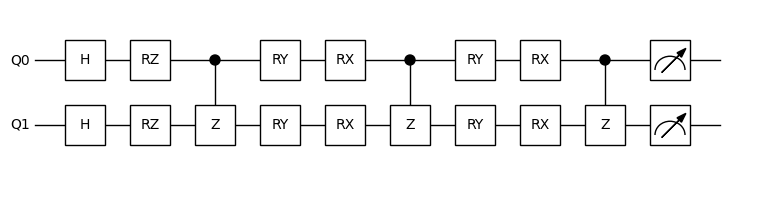

In [5]:
import tempfile
from pathlib import Path

from isqtools.draw import Drawer

backend = TorchBackend()
with tempfile.TemporaryDirectory() as temp_dir:
    temp_dir_path = Path(temp_dir)
    temp_file_path = temp_dir_path / "binary_classification.isq"
    with open(temp_file_path, "w") as temp_file:
        temp_file.write(FILE_CONTENT)
    qc = IsqCircuit(
        file=str(temp_file_path),
        backend=backend,
        sample=False,
    )


def circuit(inputs, weights):
    result = qc.pauli_measure(
        inputs=inputs,
        weights=weights,
    )
    return (result + 1) / 2


qnn = TorchLayer(
    circuit=circuit,
    num_weights=8,
    is_vmap=True,
    in_dims=(0, None),
)

dr = Drawer()
dr.plot(qc.qcis)

## Define the Loss Function

We convert the dataset to `torch.Tensor` format and extract the parameter `weights`, saving it as `params`. Then, we define the loss function.

In [6]:
X = torch.from_numpy(x.astype(np.float32))
Y = torch.from_numpy(y.astype(np.float32))
params = list(qnn.parameters())
loss_fn = nn.BCELoss()

## Train the Binary Classification Model

Using PyTorch’s automatic differentiation, we apply simple gradient descent to update the parameters.

Final loss: 0.17722681164741516


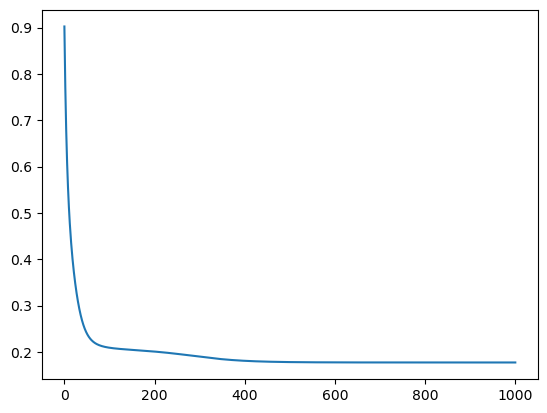

In [7]:
learning_rate = 0.1
loss_list = []
epoch = 1000
for t in range(epoch):
    y_pred = qnn(X)
    loss = loss_fn(y_pred, Y)
    loss_list.append(loss.item())
    qnn.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in qnn.parameters():
            param -= learning_rate * param.grad

print("Final loss:", loss_list[-1])
step = np.linspace(0, epoch, epoch)
plt.plot(step, np.array(loss_list))

## Model Accuracy Evaluation

We evaluate the trained model's accuracy by comparing its predictions to the true labels on the dataset.

In [8]:
output = qnn(X)
output_zeros = torch.zeros_like(output)
output_ones = torch.ones_like(output)
y_predict = torch.where(output > 0.5, output_ones, output_zeros)
print("Accuracy:", sum(y_predict.cpu().detach().numpy() == y) / len(y))

Accuracy: 0.98


We apply the trained model for classification and observe that it performs well, with only a few misclassified points. (The red circles indicate the misclassified samples.)

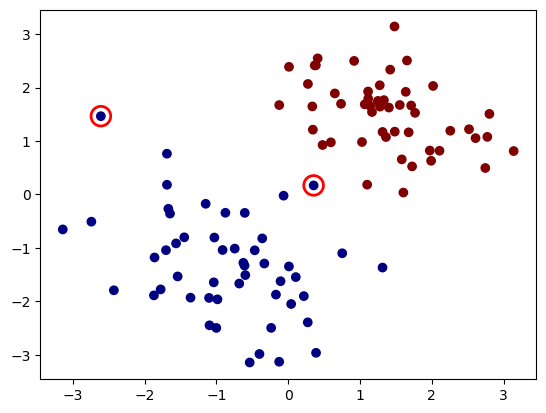

In [9]:
plt.scatter(x[:, 0], x[:, 1], c=y, cmap="jet")
for X_, Y_, y_predict_ in zip(X, Y, y_predict):
    if Y_ != y_predict_:
        plt.scatter(
            X_[0], X_[1], s=200, facecolors="none", edgecolors="r", linewidths=2
        )

## Environment Information

The following versions of software and libraries are used in this tutorial:

In [10]:
import platform
import subprocess
from importlib.metadata import version

print(f"Python version used in this tutorial: {platform.python_version()}")
print(f"Execution environment: {platform.system()} {platform.release()}\n")


isqc_version = subprocess.check_output(
    ["isqc", "-V"], stderr=subprocess.STDOUT, text=True
).strip()
print(f"isqc version: {isqc_version}")

isqtools_version = version("isqtools")
print(f"isqtools version: {isqtools_version}")

numpy_version = version("numpy")
print(f"NumPy version: {isqtools_version}")

torch_version = version("torch")
print(f"Torch version: {torch_version}")

sklearn_version = version("scikit-learn")
print(f"scikit-learn version: {sklearn_version}")

Python version used in this tutorial: 3.13.5
Execution environment: Linux 6.12.41

isqc version: isQ Compiler 0.2.5
isqtools version: 1.3.0
NumPy version: 1.3.0
Torch version: 2.7.1
scikit-learn version: 1.6.1
